In [7]:
from torch import nn , save , load
import torchvision
import torch
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [8]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
from torchvision import datasets, transforms

CIFAR_train = datasets.CIFAR10('dataTrain', train=True, download=True,
                       transform=transforms.ToTensor())

CIFAR_test = datasets.CIFAR10('dataTest', train=False, download=True, transform=
                            transforms.ToTensor())


print(CIFAR_train)
print('-----')
print(CIFAR_test)                            

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataTrain
    Split: Train
    StandardTransform
Transform: ToTensor()
-----
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataTest
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
print(CIFAR_train[0])

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

Label:  2


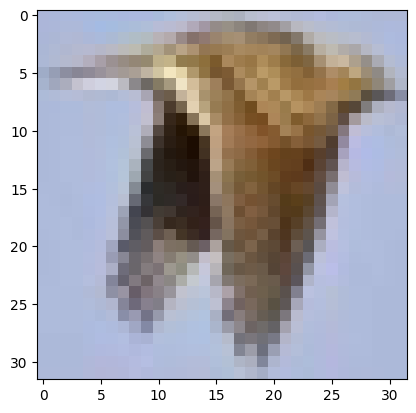

In [11]:
import matplotlib.pyplot as plt

i = 123
example = CIFAR_train[i]
print("Label: ", example[1])
plt.imshow(torchvision.utils.make_grid(example[0]).permute(1, 2, 0))
plt.show()

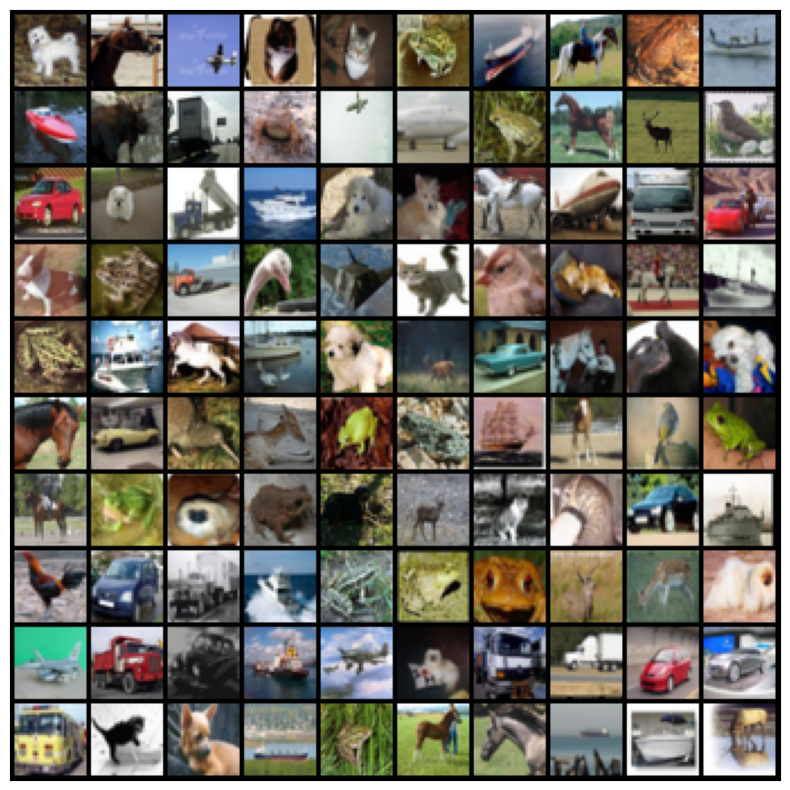

In [12]:
from torch.utils.data import DataLoader
train_dl = DataLoader(CIFAR_train, batch_size=100, shuffle=True)

dataiter = iter(train_dl)
images, labels = next(dataiter)
viz = torchvision.utils.make_grid(images, nrow=10, padding = 2).numpy()
fig, ax = plt.subplots(figsize= (10,10))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [24]:
class NN_model(nn.Module):
    def __init__(self,input_size,hidden1_size,hidden2_size,hidden3_size,output_size):
        super(NN_model,self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden1_size)
        self.fc2 = torch.nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = torch.nn.Linear(hidden2_size, hidden3_size)
        self.fc4 = torch.nn.Linear(hidden3_size, output_size)
        
    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        # out = self.softmax(out)
        return out

In [31]:
size_cifar = CIFAR_train[1][0].size()

input_size = size_cifar[0]*size_cifar[1]*size_cifar[2]
hidden1_size = 4096 
hidden2_size = 2048 
hidden3_size = 512 
num_classes = 10

In [32]:
# Checking if working correctly or not
model = NN_model(input_size, hidden1_size,hidden2_size,hidden3_size, num_classes).to(device)
print(f"CIFAR example shape:{CIFAR_train[0][0].size()}")
X = torch.randn(70,3*32*32).to(device)
print(f"Model output for X in shape: {X.size()} is {model(X).shape}")
print(f"The final model:{model}")

CIFAR example shape:torch.Size([3, 32, 32])
Model output for X in shape: torch.Size([70, 3072]) is torch.Size([70, 10])
The final model:NN_model(
  (fc1): Linear(in_features=3072, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
)


In [33]:
num_epochs = 1
batch_size = 64
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=CIFAR_train,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=CIFAR_test,batch_size=batch_size,shuffle=False)



In [40]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        images = images.reshape(images.shape[0], -1)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/1], Step [100/782], Loss: 2.1139
Epoch [1/1], Step [200/782], Loss: 1.9676
Epoch [1/1], Step [300/782], Loss: 1.8061
Epoch [1/1], Step [400/782], Loss: 1.7045
Epoch [1/1], Step [500/782], Loss: 1.7350
Epoch [1/1], Step [600/782], Loss: 1.8147
Epoch [1/1], Step [700/782], Loss: 1.7124


In [43]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} from {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()

In [44]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Got 17869 from 50000 with accuracy 35.74
Got 3575 from 10000 with accuracy 35.75
